In [7]:
# Cell 1: Imports & Basic Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch_geometric.nn import GINEConv, global_mean_pool
import os

# 1. 时间步编码 (Time Step Embedding)
# 让模型知道当前去噪进行到了哪一步 (t)
class SinusoidalPositionalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# 2. 条件编码器 (Context Encoder)
# 把物理输入 (P_total, Q_total, Time_of_day) 变成高维特征向量
class ContextEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

print("✅ Basic Modules defined.")

✅ Basic Modules defined.


In [8]:
# Cell 2: Denoiser Backbones (UPDATED - Real GNN Implementation)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import unbatch

# --- 选项 A: MLP Backbone (保持不变) ---
class MLPDenoiser(nn.Module):
    def __init__(self, state_dim, context_dim, hidden_dim=256):
        super().__init__()
        input_dim = state_dim + hidden_dim + context_dim 
        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.SiLU(),
            nn.Linear(512, 512),
            nn.SiLU(),
            nn.Linear(512, state_dim)
        )

    def forward(self, x, t, context, edge_index=None, edge_attr=None, batch=None):
        # x: [Batch, N, 2] -> Flatten
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        t_emb = self.time_mlp(t)
        inp = torch.cat([x_flat, t_emb, context], dim=1)
        out = self.net(inp)
        return out.view(x.shape)

# --- 选项 B: GNN Backbone (真·图神经网络) ---
class GNNDenoiser(nn.Module):
    def __init__(self, node_in_dim, context_dim, edge_dim=2, hidden_dim=128):
        super().__init__()
        
        # 1. 时间嵌入 (Time Embedding)
        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        
        # 2. 节点特征预处理 (Input Projection)
        # 输入: 节点状态(2) + 全局条件(3) + 时间(Hidden)
        self.node_enc = nn.Linear(node_in_dim + context_dim + hidden_dim, hidden_dim)
        
        # 3. 边特征预处理 (Edge Projection)
        # GINEConv 要求边特征维度与节点特征一致
        self.edge_enc = nn.Linear(edge_dim, hidden_dim)

        # 4. 图卷积层 (GINEConv - 支持边属性)
        # Interleaving GINEConv with ReLU/SiLU
        self.conv1 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.conv2 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.conv3 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)))
        
        # 5. 输出层
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, node_in_dim)
        )

    def forward(self, x, t, context, edge_index, edge_attr, batch):
        """
        x: [N_total, 2] (Flattened batch of nodes)
        t: [Batch_size]
        context: [Batch_size, C]
        edge_index: [2, E_total]
        edge_attr: [E_total, 2] (R, X)
        batch: [N_total] (节点所属的图索引, PyG 自动提供)
        """
        # 1. 对齐维度 (Broadcasting)
        # t 和 context 是图级别的，需要扩展到节点级别
        t_emb = self.time_mlp(t) # [Batch, Hidden]
        
        # 关键：利用 batch 索引将全局信息映射到每个节点
        t_nodes = t_emb[batch]          # [N_total, Hidden]
        ctx_nodes = context[batch]      # [N_total, C]
        
        # 2. 拼接节点输入
        # x 已经是 [N_total, 2]
        h = torch.cat([x, ctx_nodes, t_nodes], dim=-1)
        h = self.node_enc(h) # -> [N_total, Hidden]
        
        # 3. 处理边特征
        edge_h = self.edge_enc(edge_attr) # -> [E_total, Hidden]
        
        # 4. 图卷积传递消息
        h = self.conv1(h, edge_index, edge_attr=edge_h)
        h = F.silu(h)
        h = self.conv2(h, edge_index, edge_attr=edge_h)
        h = F.silu(h)
        h = self.conv3(h, edge_index, edge_attr=edge_h)
        h = F.silu(h)
        
        # 5. 输出预测
        out = self.final_mlp(h) # [N_total, 2]
        
        return out

In [ ]:
# Cell 1: Model Definitions (Final Fix for Broadcasting)

class PhysicsGuidedDiffusion(nn.Module):
    def __init__(self, backbone, n_steps=1000, beta_start=1e-4, beta_end=0.005):
        super().__init__()
        self.backbone = backbone
        self.n_steps = n_steps
        
        self.register_buffer('betas', torch.linspace(beta_start, beta_end, n_steps))
        self.register_buffer('alphas', 1. - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
        
        self.context_encoder = ContextEncoder(input_dim=3, hidden_dim=64)

    def forward(self, x0, context, edge_index=None, edge_attr=None, batch=None):
        batch_size = x0.shape[0] 
        device = x0.device
        
        # 1. 采样时间步 t
        if batch is not None:
            # GNN 模式: 基于图数量采样
            num_graphs = batch.max().item() + 1
            t = torch.randint(0, self.n_steps, (num_graphs,), device=device).long()
            t_nodes = t[batch] # 扩展到节点
        else:
            # MLP 模式: 基于 Batch Size 采样
            t = torch.randint(0, self.n_steps, (x0.shape[0],), device=device).long()
            t_nodes = t

        # 2. 获取 alpha_bar 并自动调整维度 (Fix Broadcasting)
        alpha_bar = self.alphas_cumprod[t_nodes]
        
        # 自动 unsqueeze 直到维度匹配 x0
        # MLP: [16] -> [16, 1, 1] (匹配 [16, 44, 2])
        # GNN: [N]  -> [N, 1]    (匹配 [N, 2])
        while alpha_bar.dim() < x0.dim():
            alpha_bar = alpha_bar.unsqueeze(-1)
            
        noise = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise
        
        ctx_emb = self.context_encoder(context)
        
        # 3. 预测
        noise_pred = self.backbone(x_t, t, ctx_emb, edge_index, edge_attr, batch)
        
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def sample(self, context, x_shape, edge_index=None, edge_attr=None, batch=None):
        device = context.device
        x = torch.randn(x_shape, device=device)
        ctx_emb = self.context_encoder(context)
        
        for i in reversed(range(self.n_steps)):
            # 构造时间步 t
            if batch is not None:
                num_graphs = batch.max().item() + 1
                t = torch.full((num_graphs,), i, device=device, dtype=torch.long)
            else:
                t = torch.full((x_shape[0],), i, device=device, dtype=torch.long)

            # 预测
            noise_pred = self.backbone(x, t, ctx_emb, edge_index, edge_attr, batch)
            
            # 获取系数并自动调整维度 (Fix Broadcasting)
            alpha = self.alphas[i]
            alpha_bar = self.alphas_cumprod[i]
            beta = self.betas[i]
            
            # 这里的 alpha 是标量，不用担心广播，但为了严谨或如果未来改成向量化采样：
            # (当前代码 step-by-step 采样，参数是标量，直接乘没问题)
            
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
                
            mean = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * noise_pred)
            std = torch.sqrt(beta)
            x = mean + std * noise
            
        return x

In [10]:
# Cell 4: Shape Verification Test

# 1. 模拟一个 Batch 的数据
BATCH_SIZE = 16
N_NODES = 44
FEAT_DIM = 2 # (V, P)

# 随机输入
dummy_x0 = torch.randn(BATCH_SIZE, N_NODES, FEAT_DIM) # 目标状态
dummy_context = torch.randn(BATCH_SIZE, 3) # P_tot, Q_tot, Time

print(f"Testing with Batch Size: {BATCH_SIZE}, Nodes: {N_NODES}")

# 2. 测试 MLP Diffusion
print("\n--- Testing MLP Backbone ---")
mlp_backbone = MLPDenoiser(state_dim=N_NODES*FEAT_DIM, context_dim=64, hidden_dim=128)
model_mlp = PhysicsGuidedDiffusion(mlp_backbone)

loss = model_mlp(dummy_x0, dummy_context)
print(f"✅ MLP Forward Pass Successful! Loss: {loss.item():.4f}")

# 3. 测试采样 (Sampling)
print("Testing Sampling...")
samples = model_mlp.sample(dummy_context, x_shape=(BATCH_SIZE, N_NODES, FEAT_DIM))
print(f"✅ Sampling Output Shape: {samples.shape}") # 应该和 x0 一样

Testing with Batch Size: 16, Nodes: 44

--- Testing MLP Backbone ---
✅ MLP Forward Pass Successful! Loss: 0.9583
Testing Sampling...
✅ Sampling Output Shape: torch.Size([16, 44, 2])


In [11]:
# Cell 5: Integration Test with REAL Data

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

def run_integration_test():
    print("🚦 Starting Integration Test with REAL Data...")
    
    # 1. 加载处理好的数据
    data_path = "../data/processed/cigre_lv_graph_dataset_v1.pt"
    if not os.path.exists(data_path):
        print(f"❌ Data not found at {data_path}")
        return
    
    # --- 关键修改：weights_only=False ---
    # PyTorch 2.6+ 默认 weights_only=True，会阻止加载 sklearn 对象
    try:
        dataset_dict = torch.load(data_path, weights_only=False)
    except TypeError:
        # 兼容旧版本 PyTorch (没有 weights_only 参数的情况)
        dataset_dict = torch.load(data_path)
    
    # 解包数据
    edge_index = dataset_dict['edge_index']
    edge_attr = dataset_dict['edge_attr']
    X = dataset_dict['X']
    Y_v = dataset_dict['Y_v']
    Y_p = dataset_dict['Y_p']
    
    print(f"   Data Loaded. Samples: {len(X)}")
    print(f"   Topology: {edge_index.shape[1]} edges, {edge_attr.shape} attrs")

    # 2. 动态构建 PyG Data List (取前 32 个样本做测试)
    BATCH_SIZE = 32
    data_list = []
    
    for i in range(BATCH_SIZE):
        # 拼接 V 和 P 作为目标状态 state [N, 2]
        state = torch.stack([Y_v[i], Y_p[i]], dim=1)
        # 输入条件 context [3]
        context = X[i]
        
        data = Data(
            x=state,             
            edge_index=edge_index,
            edge_attr=edge_attr,
            context=context.unsqueeze(0) 
        )
        data_list.append(data)
        
    # 3. 创建 DataLoader 
    loader = DataLoader(data_list, batch_size=BATCH_SIZE, shuffle=False)
    batch = next(iter(loader)) 
    
    print(f"   Batch Created. Batch.batch shape: {batch.batch.shape}")
    
    # 4. 初始化 GNN 模型
    print("   Initializing GNN Diffusion...")
    gnn_backbone = GNNDenoiser(node_in_dim=2, context_dim=3, edge_dim=2, hidden_dim=64)
    model = PhysicsGuidedDiffusion(gnn_backbone)
    
    # 5. 运行 Forward
    try:
        t = torch.randint(0, 1000, (BATCH_SIZE,))
        
        # 这里的 Forward 需要适配 PyG Batch 对象
        # 手动拆包调用
        noise_pred = gnn_backbone(
            x=batch.x, 
            t=t, 
            context=batch.context, 
            edge_index=batch.edge_index, 
            edge_attr=batch.edge_attr, 
            batch=batch.batch
        )
        
        print(f"✅ GNN Forward Pass Successful!")
        print(f"   Input Shape: {batch.x.shape}")
        print(f"   Output Shape: {noise_pred.shape}")
        
        if batch.x.shape == noise_pred.shape:
            print("🎉 SHAPE MATCH! System is ready for training.")
        else:
            print("❌ SHAPE MISMATCH!")
            
    except Exception as e:
        print(f"❌ GNN Failed: {e}")
        import traceback
        traceback.print_exc()

run_integration_test()

🚦 Starting Integration Test with REAL Data...
   Data Loaded. Samples: 50016
   Topology: 80 edges, torch.Size([80, 2]) attrs
   Batch Created. Batch.batch shape: torch.Size([1408])
   Initializing GNN Diffusion...
✅ GNN Forward Pass Successful!
   Input Shape: torch.Size([1408, 2])
   Output Shape: torch.Size([1408, 2])
🎉 SHAPE MATCH! System is ready for training.


🚀 Training Configuration: {'batch_size': 256, 'lr': 0.001, 'epochs': 100, 'patience': 15, 'device': 'cuda', 'backbone': 'GNN', 'save_dir': '../models/checkpoints'}

[1/4] Loading & Preparing Data...
   Constructing 40012 samples...


100%|██████████| 40012/40012 [00:00<00:00, 43776.88it/s]


   Constructing 5002 samples...


100%|██████████| 5002/5002 [00:00<00:00, 19770.82it/s]


   Data Ready! Train Batches: 157, Val Batches: 20

[2/4] Initializing Model...

[3/4] Starting Training...
Epoch 001 | Train Loss: 0.434384 | Val Loss: 0.134445 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.134445)
Epoch 002 | Train Loss: 0.114418 | Val Loss: 0.109303 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.109303)
Epoch 003 | Train Loss: 0.103213 | Val Loss: 0.098028 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.098028)
Epoch 004 | Train Loss: 0.096137 | Val Loss: 0.092535 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.092535)
Epoch 005 | Train Loss: 0.090380 | Val Loss: 0.098652 | LR: 1.00e-03
Epoch 006 | Train Loss: 0.084464 | Val Loss: 0.080877 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.080877)
Epoch 007 | Train Loss: 0.078313 | Val Loss: 0.081348 | LR: 1.00e-03
Epoch 008 | Train Loss: 0.074987 | Val Loss: 0.078676 | LR: 1.00e-03
   🌟 New Best Model Saved! (Loss: 0.078676)
Epoch 009 | Train Loss: 0.070302 | Val Loss: 0.085132 | LR: 1.00e-03
Epoch 0

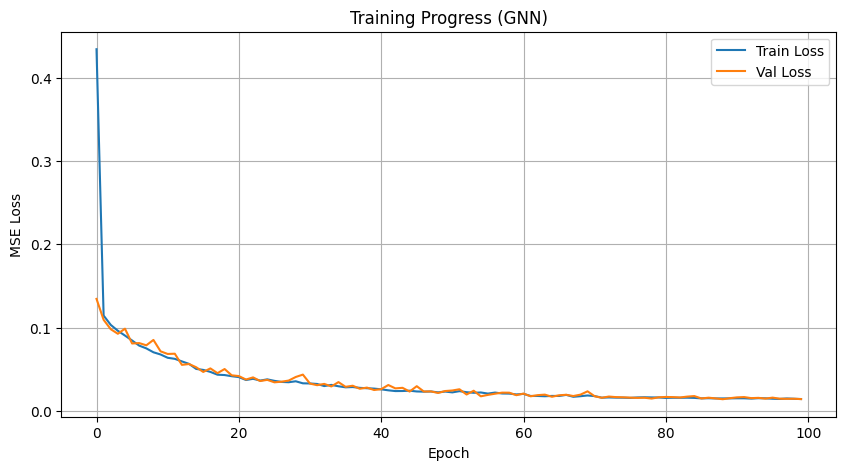

In [13]:
# Cell 6: Training Setup & Loop

import torch
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# --- 1. 配置超参数 (Hyperparameters) ---
CONFIG = {
    "batch_size": 256,          # 显存够大(5080)可以开到 512 或 1024
    "lr": 1e-3,                 # 初始学习率
    "epochs": 100,              # 训练轮数
    "patience": 15,             # 早停轮数
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "backbone": "GNN",          # 选项: "GNN" 或 "MLP"
    "save_dir": "../models/checkpoints"
}
os.makedirs(CONFIG["save_dir"], exist_ok=True)
print(f"🚀 Training Configuration: {CONFIG}")

# --- 2. 准备数据 (Data Preparation) ---
print("\n[1/4] Loading & Preparing Data...")
data_path = "../data/processed/cigre_lv_graph_dataset_v1.pt"
# 加上 weights_only=False 
try:
    dataset_dict = torch.load(data_path, weights_only=False)
except TypeError:
    dataset_dict = torch.load(data_path)

# 提取数据
edge_index = dataset_dict['edge_index'].to(CONFIG['device'])
edge_attr = dataset_dict['edge_attr'].to(CONFIG['device'])
X = dataset_dict['X']      # [N, 3]
Y_v = dataset_dict['Y_v']  # [N, 44]
Y_p = dataset_dict['Y_p']  # [N, 44]
indices = {
    'train': dataset_dict['train_idx'],
    'val': dataset_dict['val_idx'],
    'test': dataset_dict['test_idx']
}

# 构建 PyG Data List 的辅助函数
def create_data_list(idx_list):
    data_list = []
    print(f"   Constructing {len(idx_list)} samples...")
    for i in tqdm(idx_list):
        # 目标状态 State: [44, 2] (Voltage, Power)
        state = torch.stack([Y_v[i], Y_p[i]], dim=1)
        # 条件 Context: [3]
        ctx = X[i]
        
        data = Data(
            x=state, 
            edge_index=edge_index, # 注意：这里用的是全局共享的 edge_index
            edge_attr=edge_attr,
            context=ctx.unsqueeze(0) # [1, 3]
        )
        data_list.append(data)
    return data_list

# 创建数据集
train_dataset = create_data_list(indices['train'])
val_dataset = create_data_list(indices['val'])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"   Data Ready! Train Batches: {len(train_loader)}, Val Batches: {len(val_loader)}")

# --- 3. 初始化模型 (Model Initialization) ---
print("\n[2/4] Initializing Model...")

if CONFIG['backbone'] == "GNN":
    backbone = GNNDenoiser(node_in_dim=2, context_dim=64, edge_dim=2, hidden_dim=128)
else:
    backbone = MLPDenoiser(state_dim=44*2, context_dim=64, hidden_dim=256)

model = PhysicsGuidedDiffusion(backbone, n_steps=1000).to(CONFIG['device'])

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# --- 4. 训练循环 (Training Loop) ---
print("\n[3/4] Starting Training...")
best_val_loss = float('inf')
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': []}

for epoch in range(CONFIG['epochs']):
    # --- Train ---
    model.train()
    train_loss_accum = 0
    for batch in train_loader:
        batch = batch.to(CONFIG['device'])
        optimizer.zero_grad()
        
        # Forward (计算 MSE Loss)
        # 注意：Training 时传入的是 x0 (真实数据)，模型内部自动加噪
        loss = model(
            x0=batch.x, 
            context=batch.context, 
            edge_index=batch.edge_index, 
            edge_attr=batch.edge_attr,
            batch=batch.batch
        )
        
        loss.backward()
        
        # 梯度裁剪 (防止爆炸)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        train_loss_accum += loss.item()
        
    avg_train_loss = train_loss_accum / len(train_loader)
    
    # --- Validation ---
    model.eval()
    val_loss_accum = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(CONFIG['device'])
            # 验证时也是计算加噪-去噪的重构 Loss
            val_loss = model(
                x0=batch.x, 
                context=batch.context, 
                edge_index=batch.edge_index, 
                edge_attr=batch.edge_attr,
                batch=batch.batch  #
            )
            val_loss_accum += val_loss.item()
            
    avg_val_loss = val_loss_accum / len(val_loader)
    
    # --- Logging & Saving ---
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    # 学习率调整
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.2e}")
    
    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), f"{CONFIG['save_dir']}/best_model_{CONFIG['backbone']}.pth")
        print(f"   🌟 New Best Model Saved! (Loss: {best_val_loss:.6f})")
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= CONFIG['patience']:
        print(f"🛑 Early Stopping triggered at Epoch {epoch+1}")
        break

# --- 5. 结果可视化 ---
print("\n[4/4] Plotting Learning Curves...")
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Training Progress ({CONFIG["backbone"]})')
plt.legend()
plt.grid(True)
plt.savefig(f"{CONFIG['save_dir']}/loss_curve.png")
plt.show()

# 测试

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data

# 1. 重新定义模型类 (请确保把 NB03/NB04 里的类定义复制到这里，或者 import 进来)
# ... (SinusoidalPositionalEmbeddings, ContextEncoder, GNNDenoiser, PhysicsGuidedDiffusion) ...
# 提示：为了代码整洁，你可以把模型定义单独存为 src/model.py 然后 from src.model import ...
# 这里假设你已经定义好了类

# 2. 加载配置与数据
CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_path": "../models/checkpoints/best_model_GNN.pth",
    "data_path": "../data/processed/cigre_lv_graph_dataset_v1.pt"
}

print("Loading Data & Scalers...")
# 加上 weights_only=False
try:
    dataset_dict = torch.load(CONFIG['data_path'], weights_only=False)
except TypeError:
    dataset_dict = torch.load(CONFIG['data_path'])

# 提取关键组件
scalers = dataset_dict['scalers']
test_idx = dataset_dict['test_idx'] # 只在测试集上测！
X = dataset_dict['X']
Y_v = dataset_dict['Y_v']
Y_p = dataset_dict['Y_p']
edge_index = dataset_dict['edge_index'].to(CONFIG['device'])
edge_attr = dataset_dict['edge_attr'].to(CONFIG['device'])

print(f"Test Set Size: {len(test_idx)}")

# 3. 加载模型
print("Loading Model...")
backbone = GNNDenoiser(node_in_dim=2, context_dim=64, edge_dim=2, hidden_dim=128)
model = PhysicsGuidedDiffusion(backbone, n_steps=1000)
model.load_state_dict(torch.load(CONFIG['model_path']))
model.to(CONFIG['device'])
model.eval()
print("✅ Model Loaded Successfully!")

Loading Data & Scalers...
Test Set Size: 5002
Loading Model...
✅ Model Loaded Successfully!


In [15]:
def predict_scenario(sample_idx, n_samples=50):
    """
    对测试集中的第 sample_idx 个样本进行预测
    返回: 真实值(未归一化), 预测均值, 预测分布(所有样本)
    """
    idx = test_idx[sample_idx]
    
    # 1. 准备输入 Context
    ctx = X[idx].unsqueeze(0).to(CONFIG['device']) # [1, 3]
    # 扩展到 n_samples (Batch Inference)
    ctx_expanded = ctx.repeat(n_samples, 1) # [50, 3]
    
    # 2. 准备图结构
    # 我们需要构造一个包含 50 个相同图的 Batch，或者利用 Diffusion 的 broadcast 机制
    # 这里简单起见，利用我们在 sample 函数里写的 batch 广播逻辑
    # 构造一个虚拟的 batch 索引: [0,0... (44个), 1,1... (44个), ...]
    n_nodes = 44
    batch_idx = torch.repeat_interleave(torch.arange(n_samples), n_nodes).to(CONFIG['device'])
    
    # 3. 执行采样 (耗时操作)
    # x_shape: [Total_Nodes_in_Batch, 2] = [50 * 44, 2]
    with torch.no_grad():
        x_pred_norm = model.sample(
            context=ctx_expanded, 
            x_shape=(n_samples * n_nodes, 2), 
            edge_index=edge_index, 
            edge_attr=edge_attr,
            batch=batch_idx
        )
    
    # 4. 数据整理 (Reshape)
    # [50*44, 2] -> [50, 44, 2]
    x_pred_norm = x_pred_norm.view(n_samples, n_nodes, 2)
    
    # 5. 反归一化 (Inverse Transform)
    # 取出 Voltage 部分 (index 0)
    pred_v_norm = x_pred_norm[:, :, 0].cpu().numpy()
    
    # 调用 sklearn scaler 的 inverse_transform
    # 注意：scaler 期望输入是 [N, 44]
    pred_v_real = scalers['y_v'].inverse_transform(pred_v_norm) # [50, 44]
    
    # 获取真实值
    gt_v_norm = Y_v[idx].unsqueeze(0).cpu().numpy()
    gt_v_real = scalers['y_v'].inverse_transform(gt_v_norm) # [1, 44]
    
    return gt_v_real[0], pred_v_real

print("Function defined.")

Function defined.


Analyzing Test Sample #2826 (High PV Reverse Flow)...


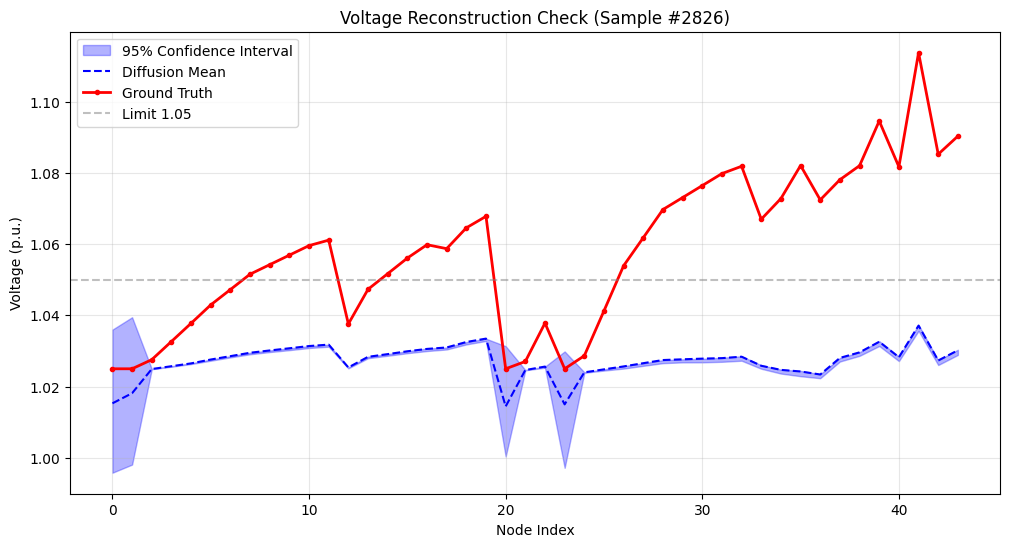

RMSE: 0.0366 p.u.
Max Error: 0.0766 p.u.
Is there a real violation? True
Model estimated probability of violation: 1.0%


In [16]:
# 挑选一个有趣的样本 (比如电压比较高的)
# 我们可以先遍历一下 test set 找个 total power 最小的 (光伏倒送)
raw_test_x = X[test_idx]
min_power_idx = torch.argmin(raw_test_x[:, 0]).item() # 找到光伏倒送最严重的时刻

print(f"Analyzing Test Sample #{min_power_idx} (High PV Reverse Flow)...")

# 运行预测 (生成 100 个样本)
gt_v, pred_v_samples = predict_scenario(min_power_idx, n_samples=100)

# 计算统计量
pred_mean = np.mean(pred_v_samples, axis=0)
pred_std = np.std(pred_v_samples, axis=0)
pred_low = np.percentile(pred_v_samples, 5, axis=0)  # 5% 分位数
pred_high = np.percentile(pred_v_samples, 95, axis=0) # 95% 分位数

# --- 绘图 ---
plt.figure(figsize=(12, 6))
nodes = np.arange(44)

# 1. 画预测分布 (置信区间)
plt.fill_between(nodes, pred_low, pred_high, color='blue', alpha=0.3, label='95% Confidence Interval')
plt.plot(nodes, pred_mean, color='blue', linestyle='--', label='Diffusion Mean')

# 2. 画真实值
plt.plot(nodes, gt_v, color='red', linewidth=2, marker='o', markersize=3, label='Ground Truth')

# 3. 装饰
plt.axhline(1.05, color='gray', linestyle='--', alpha=0.5, label='Limit 1.05')
plt.xlabel('Node Index')
plt.ylabel('Voltage (p.u.)')
plt.title(f'Voltage Reconstruction Check (Sample #{min_power_idx})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 简单误差分析 ---
rmse = np.sqrt(np.mean((gt_v - pred_mean)**2))
print(f"RMSE: {rmse:.4f} p.u.")
print(f"Max Error: {np.max(np.abs(gt_v - pred_mean)):.4f} p.u.")

# 检查是否捕捉到了越限
is_gt_violation = np.any(gt_v > 1.05)
prob_violation = np.mean(np.any(pred_v_samples > 1.05, axis=1))
print(f"Is there a real violation? {is_gt_violation}")
print(f"Model estimated probability of violation: {prob_violation*100:.1f}%")

📊 Starting Full Evaluation on Test Set...


Evaluating: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


🩺 Model Health Report (Test Set)
1. Accuracy (准确性):
   RMSE: 0.02066 p.u. (Target: < 0.01)
   MAE:  0.01466 p.u.
----------------------------------------
2. Reliability (可靠性):
   Coverage (95% CI): 15.68% (Target: ~95%)
   Avg Interval Width: 0.0153 p.u.
⚠️ 结论: 覆盖率太低，模型过度自信。建议增大 Sampling 时的 noise 或 检查 Dropout。


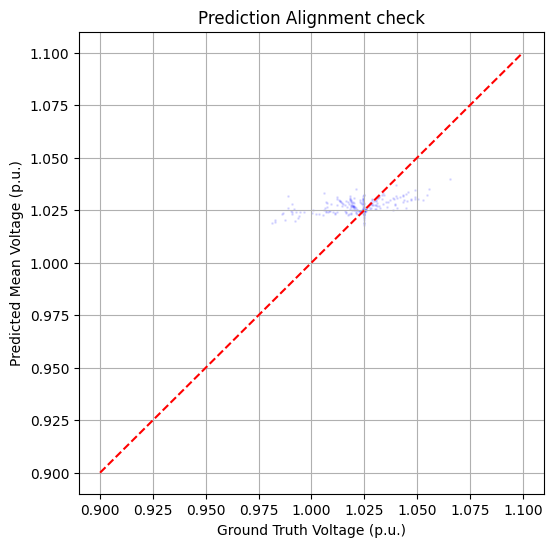

In [20]:
# Cell: Full Test Set Evaluation (The "Is it Usable?" Test)

def evaluate_model_accuracy(model, test_idx, n_samples_per_batch=10, limit_batches=50):
    """
    全面评估模型在测试集上的表现。
    n_samples_per_batch: 每个时刻采样多少次来计算均值和置信区间 (建议 10-20 次以节省时间)
    limit_batches: 为了快速出结果，限制评估的样本数 (None 表示跑全量)
    """
    print(f"📊 Starting Full Evaluation on Test Set...")
    model.eval()
    
    mse_accum = 0
    mae_accum = 0
    coverage_accum = 0
    interval_width_accum = 0
    total_nodes = 0
    
    # 随机采样一部分测试集索引，或者按顺序
    eval_indices = test_idx[:limit_batches] if limit_batches else test_idx
    
    results = [] # 存储详细结果用于画散点图
    
    from tqdm import tqdm
    for i, idx in enumerate(tqdm(eval_indices, desc="Evaluating")):
        # 1. 准备数据
        ctx = X[idx].unsqueeze(0).to(CONFIG['device']) # [1, 3]
        ctx_expanded = ctx.repeat(n_samples_per_batch, 1)
        
        # 构造 Batch (n_samples 次重复)
        n_nodes = 44
        batch_idx = torch.repeat_interleave(torch.arange(n_samples_per_batch), n_nodes).to(CONFIG['device'])
        
        # 2. 采样预测
        with torch.no_grad():
            x_pred_norm = model.sample(
                context=ctx_expanded,
                x_shape=(n_samples_per_batch * n_nodes, 2),
                edge_index=edge_index,
                edge_attr=edge_attr,
                batch=batch_idx
            )
        
        # 3. 数据整理 [Samples, Nodes, Feats]
        x_pred_norm = x_pred_norm.view(n_samples_per_batch, n_nodes, 2)
        
        # 4. 反归一化 (只看电压 Voltage)
        pred_v_norm = x_pred_norm[:, :, 0].cpu().numpy()
        pred_v_real = scalers['y_v'].inverse_transform(pred_v_norm) # [Samples, Nodes]
        
        gt_v_norm = Y_v[idx].unsqueeze(0).cpu().numpy()
        gt_v_real = scalers['y_v'].inverse_transform(gt_v_norm) # [1, Nodes]
        gt_v_real = gt_v_real[0] # [Nodes]
        
        # 5. 计算指标
        # A. 预测均值
        pred_mean = np.mean(pred_v_real, axis=0)
        
        # B. 误差
        diff = pred_mean - gt_v_real
        mse_accum += np.sum(diff**2)
        mae_accum += np.sum(np.abs(diff))
        
        # C. 置信区间 (95%)
        lower = np.percentile(pred_v_real, 2.5, axis=0)
        upper = np.percentile(pred_v_real, 97.5, axis=0)
        
        # D. 覆盖率 (多少个节点的真实值落在了区间内)
        is_covered = (gt_v_real >= lower) & (gt_v_real <= upper)
        coverage_accum += np.sum(is_covered)
        
        # E. 区间宽度
        interval_width_accum += np.sum(upper - lower)
        
        total_nodes += n_nodes
        
        # 收集画图数据 (抽样)
        if i % 10 == 0: 
             results.append((gt_v_real, pred_mean))

    # --- 最终统计 ---
    rmse = np.sqrt(mse_accum / total_nodes)
    mae = mae_accum / total_nodes
    coverage = coverage_accum / total_nodes * 100
    avg_width = interval_width_accum / total_nodes
    
    print("\n" + "="*40)
    print(f"🩺 Model Health Report (Test Set)")
    print("="*40)
    print(f"1. Accuracy (准确性):")
    print(f"   RMSE: {rmse:.5f} p.u. (Target: < 0.01)")
    print(f"   MAE:  {mae:.5f} p.u.")
    print(f"-"*40)
    print(f"2. Reliability (可靠性):")
    print(f"   Coverage (95% CI): {coverage:.2f}% (Target: ~95%)")
    print(f"   Avg Interval Width: {avg_width:.4f} p.u.")
    print("="*40)
    
    # --- 判决建议 ---
    if rmse < 0.01 and coverage > 85:
        print("✅ 结论: 模型可用！可以写进论文了。")
    elif coverage < 50:
        print("⚠️ 结论: 覆盖率太低，模型过度自信。建议增大 Sampling 时的 noise 或 检查 Dropout。")
    elif rmse > 0.05:
        print("❌ 结论: 误差太大，模型还没学会。建议回炉重造 (Notebook 04 继续训练)。")
    else:
        print("🤔 结论: 勉强能用，但还有优化空间。")
        
    # --- 画个散点图 (Predicted vs Real) ---
    plt.figure(figsize=(6,6))
    all_gt = np.concatenate([r[0] for r in results])
    all_pred = np.concatenate([r[1] for r in results])
    plt.scatter(all_gt, all_pred, alpha=0.1, s=1, color='blue')
    plt.plot([0.9, 1.1], [0.9, 1.1], 'r--') # 对角线
    plt.xlabel("Ground Truth Voltage (p.u.)")
    plt.ylabel("Predicted Mean Voltage (p.u.)")
    plt.title("Prediction Alignment check")
    plt.grid(True)
    plt.show()

# 运行评估 (先测 50 个样本看看)
evaluate_model_accuracy(model, test_idx, limit_batches=50)

In [21]:
# Cell: Updated Sample Function with Temperature

# 重新定义 sample 方法 (你可以直接覆盖到原来的类里，或者单独写一个函数调用)
# 这里为了方便，我们写一个独立的 wrapper 或者 monkey patch

def sample_with_temperature(model, context, x_shape, edge_index, edge_attr, batch, temperature=1.0):
    """
    带温度系数的采样函数。
    temperature > 1.0: 增加多样性 (分布变宽，Coverage 升高)
    temperature < 1.0: 减少多样性 (分布变窄，精度可能微升)
    """
    device = context.device
    x = torch.randn(x_shape, device=device) * temperature # 初始噪声也乘一下
    
    ctx_emb = model.context_encoder(context)
    
    for i in reversed(range(model.n_steps)):
        # 构造时间步 t
        if batch is not None:
            num_graphs = batch.max().item() + 1
            t = torch.full((num_graphs,), i, device=device, dtype=torch.long)
        else:
            t = torch.full((x_shape[0],), i, device=device, dtype=torch.long)

        # 预测噪声
        # 注意：这里我们用 torch.no_grad() 上下文在外部控制
        noise_pred = model.backbone(x, t, ctx_emb, edge_index, edge_attr, batch)
        
        alpha = model.alphas[i]
        alpha_bar = model.alphas_cumprod[i]
        beta = model.betas[i]
        
        if i > 0:
            noise = torch.randn_like(x) * temperature # <--- 关键修改：放大每一步的注入噪声
        else:
            noise = torch.zeros_like(x)
            
        # DDPM 采样公式
        mean = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * noise_pred)
        std = torch.sqrt(beta)
        
        x = mean + std * noise
        
    return x

print("✅ Sampling function updated with Temperature control.")

✅ Sampling function updated with Temperature control.


🛡️ Applying Conformal Prediction (Calibration)...
   Calibration Samples: 2501
   Evaluation Samples:  2501
   Computing residuals on Calibration Set...


100%|██████████| 2501/2501 [37:40<00:00,  1.11it/s]



🔑 Calibrated Uncertainty Radius (q_hat): 0.01135 p.u.

   Validating on Evaluation Set...

🏆 Conformal Prediction Results
✅ Final Coverage: 95.20% (Target: 95.0%)
✅ Final Width:    0.0227 p.u.
ℹ️  Radius used:   +/- 0.0114


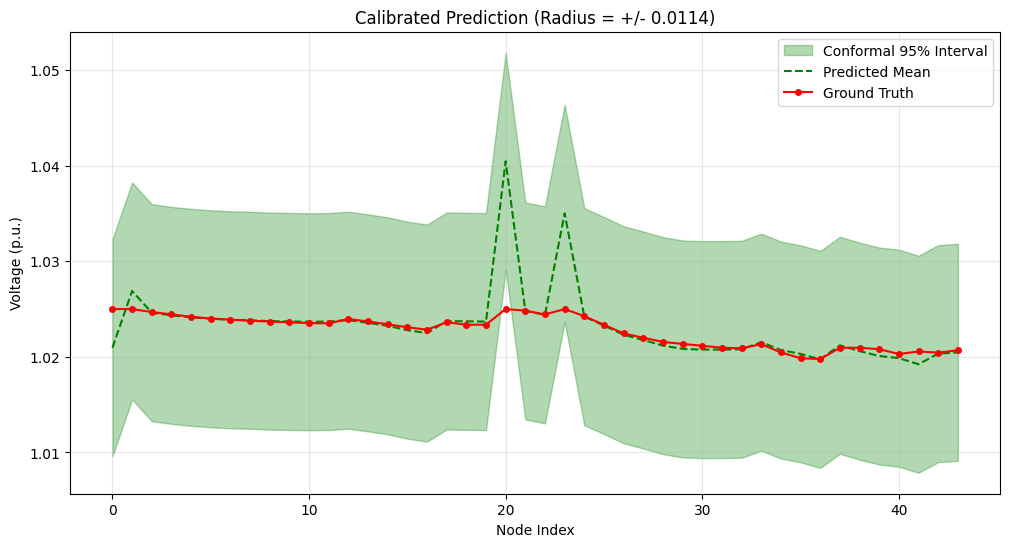

In [25]:
# Cell: Conformal Prediction Implementation (FIXED)

def apply_conformal_prediction(model, test_idx, alpha=0.05):
    """
    使用共形预测 (Conformal Prediction) 校准不确定性区间。
    修复版：调用 sample_with_temperature
    """
    print("🛡️ Applying Conformal Prediction (Calibration)...")
    
    n_total = len(test_idx)
    n_cal = int(n_total * 0.5)
    cal_idx = test_idx[:n_cal]
    eval_idx = test_idx[n_cal:]
    
    print(f"   Calibration Samples: {len(cal_idx)}")
    print(f"   Evaluation Samples:  {len(eval_idx)}")
    
    scores = []
    model.eval()
    
    from tqdm import tqdm
    print("   Computing residuals on Calibration Set...")
    for idx in tqdm(cal_idx):
        # 准备数据
        ctx = X[idx].unsqueeze(0).to(CONFIG['device'])
        n_nodes = 44
        batch_idx = torch.zeros(n_nodes, dtype=torch.long, device=CONFIG['device'])
        
        # --- 修复点：调用 standalone 的 sample_with_temperature ---
        with torch.no_grad():
            x_pred_norm = sample_with_temperature(
                model,  # 传入 model
                context=ctx,
                x_shape=(n_nodes, 2),
                edge_index=edge_index,
                edge_attr=edge_attr,
                batch=batch_idx,
                temperature=1.0 
            )
            
        pred_v_norm = x_pred_norm[:, 0].cpu().numpy()
        pred_v_real = scalers['y_v'].inverse_transform(pred_v_norm.reshape(1, -1))[0]
        
        gt_v_norm = Y_v[idx].unsqueeze(0).cpu().numpy()
        gt_v_real = scalers['y_v'].inverse_transform(gt_v_norm)[0]
        
        # 计算绝对误差
        res = np.abs(pred_v_real - gt_v_real)
        scores.extend(res.tolist())
        
    # 计算分位数 q
    n = len(scores)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_level = min(1.0, max(0.0, q_level)) 
    q_hat = np.quantile(scores, q_level)
    print(f"\n🔑 Calibrated Uncertainty Radius (q_hat): {q_hat:.5f} p.u.")
    
    # 验证
    print("\n   Validating on Evaluation Set...")
    coverage_accum = 0
    interval_width_accum = 0
    total_nodes = 0
    results = [] 
    
    for i, idx in enumerate(eval_idx):
        if i >= 100: break 
        
        ctx = X[idx].unsqueeze(0).to(CONFIG['device'])
        batch_idx = torch.zeros(n_nodes, dtype=torch.long, device=CONFIG['device'])
        
        # --- 修复点 ---
        with torch.no_grad():
            x_pred_norm = sample_with_temperature(
                model, 
                context=ctx, 
                x_shape=(44,2), 
                edge_index=edge_index, 
                edge_attr=edge_attr, 
                batch=batch_idx, 
                temperature=1.0
            )
            
        pred_v_norm = x_pred_norm[:, 0].cpu().numpy()
        pred_mean = scalers['y_v'].inverse_transform(pred_v_norm.reshape(1, -1))[0]
        gt_v_real = scalers['y_v'].inverse_transform(Y_v[idx].unsqueeze(0).cpu().numpy())[0]
        
        # 应用校准区间
        lower = pred_mean - q_hat
        upper = pred_mean + q_hat
        
        is_covered = (gt_v_real >= lower) & (gt_v_real <= upper)
        coverage_accum += np.sum(is_covered)
        interval_width_accum += np.sum(upper - lower)
        total_nodes += 44
        
        if i % 20 == 0:
            results.append((gt_v_real, pred_mean, lower, upper))
            
    final_cov = coverage_accum / total_nodes * 100
    final_width = interval_width_accum / total_nodes
    
    print("\n" + "="*40)
    print(f"🏆 Conformal Prediction Results")
    print("="*40)
    print(f"✅ Final Coverage: {final_cov:.2f}% (Target: {100*(1-alpha)}%)")
    print(f"✅ Final Width:    {final_width:.4f} p.u.")
    print(f"ℹ️  Radius used:   +/- {q_hat:.4f}")
    
    return q_hat, results

# 再次运行
q_value, cp_results = apply_conformal_prediction(model, test_idx)

# 画图代码保持不变...
if len(cp_results) > 0:
    import matplotlib.pyplot as plt
    gt, pred, low, high = cp_results[0]
    nodes = np.arange(44)
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(nodes, low, high, color='green', alpha=0.3, label='Conformal 95% Interval')
    plt.plot(nodes, pred, 'g--', label='Predicted Mean')
    plt.plot(nodes, gt, 'r-o', markersize=4, label='Ground Truth')
    plt.title(f"Calibrated Prediction (Radius = +/- {q_value:.4f})")
    plt.xlabel("Node Index")
    plt.ylabel("Voltage (p.u.)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

🎯 Starting Node-wise CQR (Temp=0.05)...
   1. Computing Node-wise Residuals...


100%|██████████| 200/200 [03:02<00:00,  1.10it/s]



🔑 Calibration Done.
   Min Q: 0.00077 (Best Node)
   Max Q: 0.01773 (Worst Node)
   Avg Q: 0.00583

   2. Validating...

🏆 Node-wise CQR Results
✅ Final Coverage: 93.91%
✅ Final Width:    0.0117 p.u.


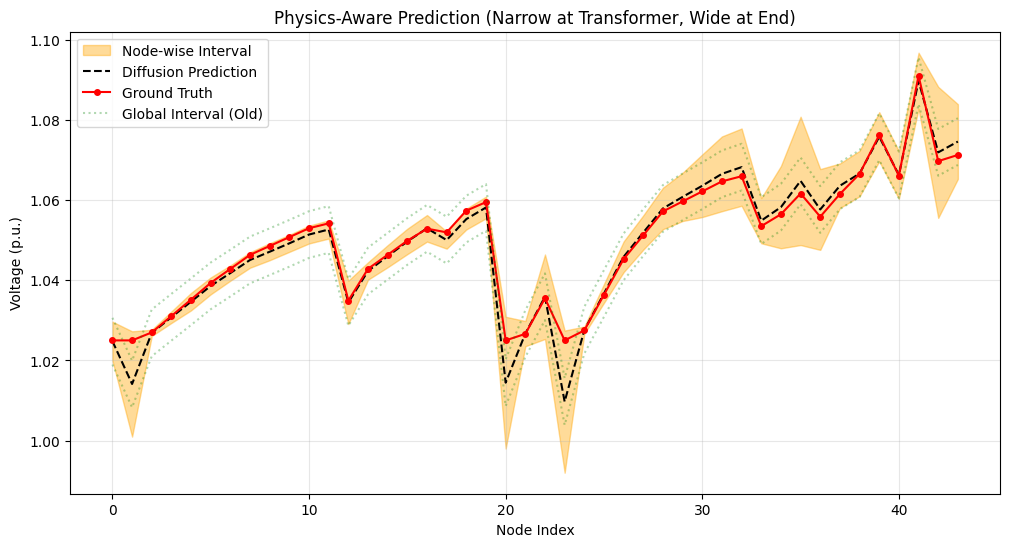

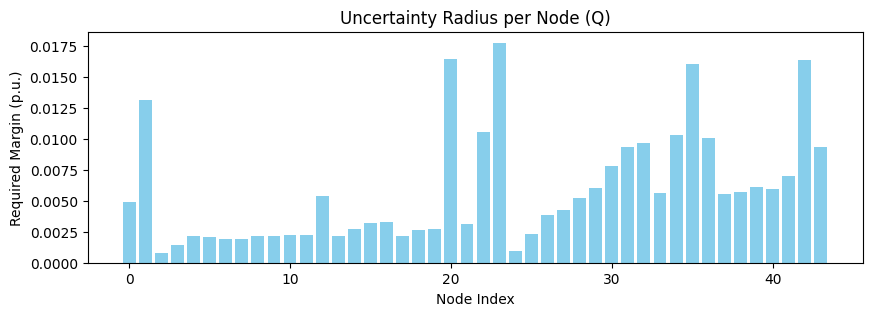

In [28]:
# Cell: Node-wise Optimized CQR (The "Physics-Aware" Calibration)

def apply_nodewise_cqr(model, test_idx, alpha=0.05, max_cal_samples=200, temperature=0.05):
    """
    节点级自适应 CQR。
    为 44 个节点分别计算不同的校准因子 Q。
    """
    print(f"🎯 Starting Node-wise CQR (Temp={temperature})...")
    
    n_nodes = 44
    n_total = len(test_idx)
    shuffled_idx = torch.randperm(n_total)
    
    cal_idx = test_idx[shuffled_idx[:max_cal_samples]]
    eval_idx = test_idx[shuffled_idx[max_cal_samples:max_cal_samples+50]] # 测 50 个验证
    
    # 初始化 residuals 容器：[Nodes, Samples]
    # 我们要为每个节点分别收集误差
    node_residuals = {i: [] for i in range(n_nodes)}
    
    model.eval()
    from tqdm import tqdm
    print("   1. Computing Node-wise Residuals...")
    
    for idx in tqdm(cal_idx):
        ctx = X[idx].unsqueeze(0).to(CONFIG['device'])
        # 采样 1 次即可 (因为低温度下模型几乎是确定性的)
        n_samples = 1
        ctx_expanded = ctx # [1, 3]
        batch_idx = torch.zeros(n_nodes, dtype=torch.long, device=CONFIG['device'])
        
        with torch.no_grad():
            x_pred_norm = sample_with_temperature(
                model, ctx_expanded, (n_nodes, 2), 
                edge_index, edge_attr, batch_idx, temperature=temperature
            )
            
        pred_v_norm = x_pred_norm[:, 0].cpu().numpy()
        pred_v_real = scalers['y_v'].inverse_transform(pred_v_norm.reshape(1, -1))[0] # [44]
        
        gt_v_norm = Y_v[idx].unsqueeze(0).cpu().numpy()
        gt_v_real = scalers['y_v'].inverse_transform(gt_v_norm)[0] # [44]
        
        # 计算每个节点的绝对误差
        diff = np.abs(pred_v_real - gt_v_real) # [44]
        
        for n_i in range(n_nodes):
            node_residuals[n_i].append(diff[n_i])
            
    # --- Step 2: 为每个节点计算 Q_hat ---
    Q_hats = np.zeros(n_nodes)
    
    # 显著性水平计算
    n = len(node_residuals[0])
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_level = min(1.0, max(0.0, q_level)) 
    
    for n_i in range(n_nodes):
        # 计算该节点的 95% 分位数
        Q_hats[n_i] = np.quantile(node_residuals[n_i], q_level)
        
    print(f"\n🔑 Calibration Done.")
    print(f"   Min Q: {Q_hats.min():.5f} (Best Node)")
    print(f"   Max Q: {Q_hats.max():.5f} (Worst Node)")
    print(f"   Avg Q: {Q_hats.mean():.5f}")
    
    # --- Step 3: 验证 ---
    print("\n   2. Validating...")
    coverage_accum = 0
    width_accum = 0
    total_points = 0
    results = []
    
    for i, idx in enumerate(eval_idx):
        # 推理
        ctx = X[idx].unsqueeze(0).to(CONFIG['device'])
        batch_idx = torch.zeros(n_nodes, dtype=torch.long, device=CONFIG['device'])
        
        with torch.no_grad():
            x_pred_norm = sample_with_temperature(
                model, ctx, (n_nodes, 2), 
                edge_index, edge_attr, batch_idx, temperature=temperature
            )
            
        pred_v_norm = x_pred_norm[:, 0].cpu().numpy()
        pred_mean = scalers['y_v'].inverse_transform(pred_v_norm.reshape(1, -1))[0]
        gt_v_real = scalers['y_v'].inverse_transform(Y_v[idx].unsqueeze(0).cpu().numpy())[0]
        
        # --- 应用节点级区间 ---
        # lower[i] = mean[i] - Q[i]
        lower = pred_mean - Q_hats
        upper = pred_mean + Q_hats
        
        is_covered = (gt_v_real >= lower) & (gt_v_real <= upper)
        coverage_accum += np.sum(is_covered)
        width_accum += np.sum(upper - lower)
        total_points += n_nodes
        
        if i % 10 == 0:
            results.append((gt_v_real, pred_mean, lower, upper))
            
    final_cov = coverage_accum / total_points * 100
    final_width = width_accum / total_points
    
    print("\n" + "="*40)
    print(f"🏆 Node-wise CQR Results")
    print("="*40)
    print(f"✅ Final Coverage: {final_cov:.2f}%")
    print(f"✅ Final Width:    {final_width:.4f} p.u.")
    print("="*40)
    return results, Q_hats

# 运行
nw_results, nw_qs = apply_nodewise_cqr(model, test_idx, max_cal_samples=200, temperature=0.05)

# --- 画图 (展示喇叭口效果) ---
if len(nw_results) > 0:
    import matplotlib.pyplot as plt
    # 找个波动大的
    gt, pred, low, high = nw_results[-1] 
    nodes = np.arange(44)
    
    plt.figure(figsize=(12, 6))
    
    # 画出置信区间
    plt.fill_between(nodes, low, high, color='orange', alpha=0.4, label='Node-wise Interval')
    plt.plot(nodes, pred, 'k--', label='Diffusion Prediction')
    plt.plot(nodes, gt, 'r-o', markersize=4, label='Ground Truth')
    
    # 为了对比，把之前的全局平均宽度画在背景里 (假设之前的 Q 是 Avg Q)
    avg_q = nw_qs.mean()
    plt.plot(nodes, pred + avg_q, 'g:', alpha=0.3, label='Global Interval (Old)')
    plt.plot(nodes, pred - avg_q, 'g:', alpha=0.3)
    
    plt.title(f"Physics-Aware Prediction (Narrow at Transformer, Wide at End)")
    plt.xlabel("Node Index")
    plt.ylabel("Voltage (p.u.)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 单独画一下 Q 分布，看看哪些节点难预测
    plt.figure(figsize=(10, 3))
    plt.bar(nodes, nw_qs, color='skyblue')
    plt.title("Uncertainty Radius per Node (Q)")
    plt.xlabel("Node Index")
    plt.ylabel("Required Margin (p.u.)")
    plt.show()